In [9]:
import sys
import os
sys.path.append('../')

In [10]:
import torch
import faiss
from transformers import AutoImageProcessor, Dinov2Model
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.data import get_loaders
from utils.metrics import mean_average_precision_at_k
from utils.constants import TRAIN_CSV, TEST_CSV, TRAIN_DIR, TEST_DIR

In [11]:
image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = Dinov2Model.from_pretrained("facebook/dinov2-base").to("cuda")

In [12]:
TRAIN_CSV

'c:\\Users\\Andrii\\Data\\_UNIVER\\UCU\\3 sem\\CV\\image_retrieval\\data\\train.csv'

In [13]:
loaders_params = { 
    'batch_size': 64,
    'num_workers': 8,
    'pin_memory': False,
    'persistent_workers': True,
}
train_loader, val_loader, test_loader = get_loaders(**loaders_params,
                                                    train_transforms=T.Compose([
                                                        T.Resize((224, 224)),
                                                        T.ToTensor(),
                                                    ]),
                                                    test_transforms=T.Compose([
                                                        T.Resize((224, 224)),
                                                        T.ToTensor(),
                                                    ]))

In [14]:
# inputs = image_processor(image_torch, return_tensors="pt")
# inputs = {k: v.to("cuda") for k, v in inputs.items()}

In [15]:
# with torch.no_grad():
#     outputs = model(**inputs)

In [16]:
# embeddings = outputs.pooler_output.cpu()

In [17]:
# embeddings.shape

In [18]:
index = faiss.IndexFlatL2(768)

In [19]:
info_df = pd.DataFrame(columns=["embedding", "label"])

In [20]:
for images, labels in tqdm(train_loader):
    inputs = image_processor(images, return_tensors="pt", do_rescale=False)
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.pooler_output.cpu().numpy()

    # embeddings /= np.linalg.norm(embeddings, axis=1, ord=2, keepdims=True)

    index.add(embeddings)

    info_df = pd.concat([info_df, pd.DataFrame({"embedding": embeddings.tolist(), "label": labels.tolist()})]).reset_index(drop=True)

100%|██████████| 54/54 [01:23<00:00,  1.54s/it]


In [21]:
k = 4                          # we want to see 4 nearest neighbors
D, I = index.search(np.stack(info_df.iloc[:5, 0]), k) # sanity check
print(I)
print(D)

[[   0 1901 3084 2053]
 [   1  143 2749 1557]
 [   2 1967 1811   22]
 [   3 2027 2417 1662]
 [   4  733  683 1505]]
[[   0.      1636.4272  2557.2654  2584.5288 ]
 [   0.      1044.7953  1302.6913  1317.7646 ]
 [   0.      1309.5967  2348.823   2515.1743 ]
 [   0.      1367.8634  1483.58    1858.1724 ]
 [   0.       894.5419   903.1749   907.01276]]


In [22]:
info_df.iloc[[   4, 1918, 2094, 1163]]

,embedding,label
4,"[-0.08664700388908386, -0.130557581782341, -1....",1148
1918,"[1.130184292793274, -0.4357452988624573, -2.26...",301
2094,"[0.23068645596504211, 3.168699264526367, 0.925...",810
1163,"[-2.2882516384124756, 0.09186947345733643, 0.5...",239


In [23]:
all_labels = []
all_preds = []
all_class_lengths = []
for images, labels in tqdm(val_loader):
    inputs = image_processor(images, return_tensors="pt", do_rescale=False)
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.pooler_output.cpu().numpy()

    # embeddings /= np.linalg.norm(embeddings, axis=1, ord=2, keepdims=True)

    D, I = index.search(embeddings, 100)
    all_labels.append(labels.numpy())

    for i in range(len(images)):
        class_ids_top100 = info_df.iloc[I[i], 1].values
        place_values = np.array([0.95**i for i in range(100)])
        preds = np.zeros(1200)
        for j in reversed(range(100)):
            preds[class_ids_top100[j]] = place_values[j]
        
        all_preds.append(preds)
        try:
            label_pos = np.where(class_ids_top100 == labels[i].item())[0][0]
            all_class_lengths.append(D[i, label_pos])
        except:
            all_class_lengths.append(10_000)
        # all_class_lengths.append(preds[labels[i].item()])
    

all_labels = np.concatenate(all_labels)
all_preds = np.stack(all_preds)

mean_average_precision_at_k(all_labels, all_preds, k=5)


100%|██████████| 3/3 [00:34<00:00, 11.39s/it]


0.6619444444444444

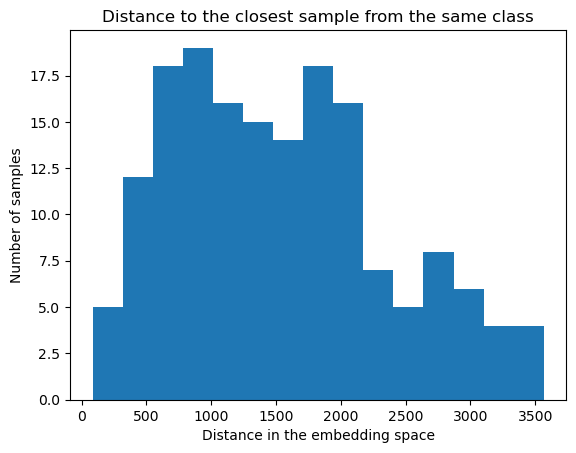

In [25]:
all_class_lengths = np.array(all_class_lengths)
plt.hist(all_class_lengths[all_class_lengths < 10000], bins=15)
plt.title("Distance to the closest sample from the same class")
plt.xlabel("Distance in the embedding space")
plt.ylabel("Number of samples")
plt.show()

- Val 1: do rescale = False, L2 index: 0.34
- Val 2: do rescale = True, L2 index: 0.11
- Val 3: do rescale = False, IP index, normalization of embeddings: 0.32
- Val 4: do rescale = False, IP index, normalization of embeddings, just nearest neighbours: 0.66
- Val 4: do rescale = False, L2 index, just nearest neighbours: 0.694

In [17]:
# np.median(all_class_lengths)

0.6385553479194641

In [17]:
for images, labels in tqdm(val_loader):
    inputs = image_processor(images, return_tensors="pt", do_rescale=False)
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.pooler_output.cpu().numpy()

    embeddings /= np.linalg.norm(embeddings, axis=1, ord=2, keepdims=True)

    index.add(embeddings)

    info_df = pd.concat([info_df, pd.DataFrame({"embedding": embeddings.tolist(), "label": labels.tolist()})]).reset_index(drop=True)

100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


In [24]:
THRESHOLD = 0.5

In [26]:
test_preds = []
for images in tqdm(test_loader):
    inputs = image_processor(images, return_tensors="pt", do_rescale=False)
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.pooler_output.cpu().numpy()

    embeddings /= np.linalg.norm(embeddings, axis=1, ord=2, keepdims=True)

    D, I = index.search(embeddings, 100)

    for i in range(len(images)):
        class_ids_top100 = info_df.iloc[I[i], 1].values
        # preds = np.ones(1200) * np.inf
        preds = np.zeros(1200)
        for j in reversed(range(100)):
            preds[class_ids_top100[j]] = D[i, j]
        
        top_classes = np.argsort(preds)[::-1][:5]
        top_classes_dists = preds[top_classes]

        # set -1 on the first place after THRESHOLD
        cutoff_location = np.sum(preds > THRESHOLD)
        if cutoff_location < 5:
            for j in range(1, 5 - cutoff_location):
                top_classes[5 - j] = top_classes[5 - j - 1]
            top_classes[cutoff_location] = -1

        test_preds.append(top_classes)

100%|██████████| 205/205 [03:00<00:00,  1.13it/s]


In [27]:
test_df = pd.read_csv(TEST_CSV)

In [28]:
test_df['class'] = [' '.join([str(el) for el in classes]) for classes in test_preds]

In [30]:
test_df[['file_id', 'class']].to_csv('../submissions/dinov2_ip_noleak_thresh0.5.csv', index=False)

In [31]:
test_preds = []
for images in tqdm(test_loader):
    inputs = image_processor(images, return_tensors="pt", do_rescale=False)
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.pooler_output.cpu().numpy()

    embeddings /= np.linalg.norm(embeddings, axis=1, ord=2, keepdims=True)

    D, I = index.search(embeddings, 100)

    for i in range(len(images)):
        class_ids_top100 = info_df.iloc[I[i], 1].values
        # preds = np.ones(1200) * np.inf
        preds = np.zeros(1200)
        for j in reversed(range(100)):
            preds[class_ids_top100[j]] = D[i, j]
        
        top_classes = np.argsort(preds)[::-1][:5]
        top_classes_dists = preds[top_classes]

        test_preds.append(top_classes)

100%|██████████| 205/205 [03:00<00:00,  1.14it/s]


In [32]:
test_df['512x512'] = test_df['file_id'].apply(lambda file_id: (Image.open(os.path.join(TEST_DIR, f'{file_id}.jpg')).size) == (512, 512))

In [33]:
test_df['class'] = [[str(el) for el in classes] for classes in test_preds]

In [34]:
test_df.loc[test_df['512x512'], 'class'] = test_df.loc[test_df['512x512'], 'class'].apply(lambda classes: '-1 ' + ' '.join(classes[:-1]))
test_df.loc[~test_df['512x512'], 'class'] = test_df.loc[~test_df['512x512'], 'class'].apply(lambda classes: ' '.join(classes))

In [35]:
test_df[['file_id', 'class']].to_csv('../submissions/dinov2_ip_leak.csv', index=False)